# I. Import libaries and set parameters:

In [1]:
import tensorflow as tf
import pandas as pd
import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
ROOT = "/home/jupyter/lung_segmentation"
DATA_DIR = "/home/jupyter/lung_segmentation/lung_seg"
ORI_PATH = "/home/jupyter/lung_segmentation/lung_seg/CXR_png/"
MASK_PATH = "/home/jupyter/lung_segmentation/lung_seg/masks/"
CROP_PATH = "/home/jupyter/lung_x_ray/data/CheXpert-v1.0-small/val_frontal_cropped"

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# II. Build Model:

## 1. Load image function:

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image, channels=3)
  image = tf.cast(image, tf.float32)

  return image

In [5]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [6]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [7]:
def normalize(input_image, real_image):
  """ Normalizing the images to [-1, 1]
  """
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [8]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [9]:
def load_image(ori_file, mask_file):
  ori_file = load(ori_file)
  mask_file = load(mask_file)
  ori_file, mask_file = random_jitter(ori_file, mask_file)
  ori_file, mask_file = normalize(ori_file, mask_file)

  return ori_file, mask_file

## 2. Train set and Validation set:

In [10]:
images = os.listdir('/home/jupyter/lung_segmentation/lung_seg/CXR_png/')
mask = os.listdir('/home/jupyter/lung_segmentation/lung_seg/masks/')
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [11]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [12]:
ori_image_path = []
for i in check:
    a = os.path.join(ORI_PATH, i.split('_mask')[0] + ".png")
    ori_image_path.append(a)

In [13]:
mask_image_path = []
for i in check:
    a = os.path.join(MASK_PATH, i + ".png")
    mask_image_path.append(a)

In [14]:
len(mask_image_path)

566

In [15]:
len(ori_image_path)

566

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((ori_image_path, mask_image_path))
train_dataset = train_dataset.map(load_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices(([DATA_DIR+'/CXR_png/CHNCXR_0001_0.png'], [DATA_DIR+'/masks/CHNCXR_0001_0_mask.png']))
test_dataset = test_dataset.map(load_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [18]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

## 3. Build the Generator

### a. Model:

In [19]:
OUTPUT_CHANNELS = 3

In [20]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [21]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                                kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [22]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
      downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
      downsample(128, 4), # (bs, 64, 64, 128)
      downsample(256, 4), # (bs, 32, 32, 256)
      downsample(512, 4), # (bs, 16, 16, 512)
      downsample(512, 4), # (bs, 8, 8, 512)
      downsample(512, 4), # (bs, 4, 4, 512)
      downsample(512, 4), # (bs, 2, 2, 512)
      downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
      upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
      upsample(512, 4), # (bs, 16, 16, 1024)
      upsample(256, 4), # (bs, 32, 32, 512)
      upsample(128, 4), # (bs, 64, 64, 256)
      upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
      x = down(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()

### b. Generator loss

In [26]:
LAMBDA = 100

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## 4. Build the Discriminator

### a. Model:

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()

### b. Discriminator loss

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## 5. Define the Optimizers and Checkpoint-saver

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# III. Training

In [263]:
EPOCHS = 150

In [264]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [265]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [266]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    # Visualize training process 
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

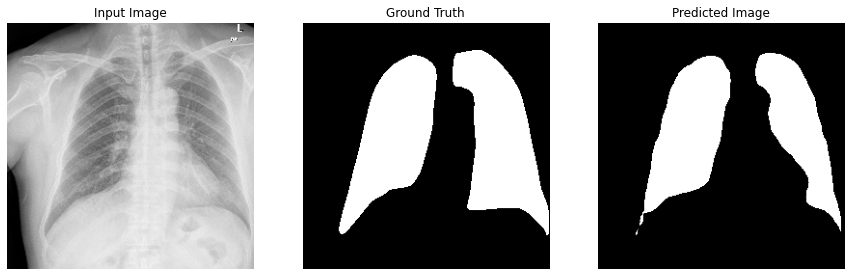

Epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................................
Time taken for epoch 150 is 51.08893823623657 sec



In [267]:
fit(train_dataset, EPOCHS, test_dataset)

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# IV. Function to automate crop images:

In [50]:
import cv2
import numpy as np

## 1. Helper Functions for Implement code:

In [51]:
def resize_final(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image

In [52]:
def random_crop_final(input_image):
  stacked_image = tf.stack([input_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[1, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0]

In [53]:
def normalize_final(input_image):
  """ Normalizing the images to [-1, 1]
  """
  input_image = (input_image / 127.5) - 1

  return input_image

In [54]:
def de_normalize_final(input_image):
  """ Normalizing the images to [-1, 1]
  """
  input_image = (input_image + 1) * 127.5

  return input_image

In [55]:
@tf.function()
def random_jitter_final(input_image):
  # resizing to 256 x 256 x 3
  input_image = resize_final(input_image, 256, 256)

  return input_image

In [56]:
def load_final(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image, channels=3)
  image = tf.cast(image, tf.float32)

  return image

In [57]:
def load_image_final(img):
    nam = img.split("/")[-1][:-4]
    img = load_final(img)
    img = random_jitter_final(img)
    img = normalize_final(img)

    return img, nam

In [58]:
def predict_images(model, test_input):
    prediction = model(test_input, training=True)
    return prediction[0] * 0.5 + 0.5


In [59]:
def crop_minAreaRect(img, rect):
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    pts = np.int0(box)  
    pts[pts < 0] = 0

    # crop
    img_crop = img[pts[1][1]:pts[0][1], 
                       pts[1][0]:pts[2][0]]

    return img_crop

In [60]:
def final_image_generator(model, test_input):
    test_input, nam = load_image_final(test_input)

    test_ori = np.float32(test_input)
    test_ori = de_normalize_final(test_ori)

    test_input = tf.expand_dims(test_input, axis=0)
    image = predict_images(model, test_input)
    image = np.float32(image) * 255
    
    thresh = 127
    image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    kernel_open = np.ones((2,2))

    mask_open = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel_open)

    image_edit = mask_open.copy()

    points = cv2.findNonZero(image_edit)
    rect = cv2.minAreaRect(points)

    # crop
    img_croped = crop_minAreaRect(test_ori, rect)

    

    return nam, img_croped

## 2. Load images and crop:

In [93]:
data_t = pd.read_csv('/home/jupyter/lung_x_ray/data/CheXpert-v1.0-small/train_edit.csv')
data_v = pd.read_csv('/home/jupyter/lung_x_ray/data/CheXpert-v1.0-small/valid_edit.csv')

In [94]:
data_train = data_t[data_t['Frontal/Lateral'] == 'Frontal']
data_train['img_path'] = '/home/jupyter/lung_x_ray/data/' + data_train['Path']
data_train = data_train[['img_path']]

data_valid = data_v[data_v['Frontal/Lateral'] == 'Frontal']
data_valid['img_path'] = '/home/jupyter/lung_x_ray/data/' + data_valid['Path']
data_valid = data_valid[['img_path']]

In [ ]:
train_list = list(data_train['img_path'])

valid_list = list(data_valid['img_path'])

In [65]:
def crop_img(crop_list):
    len_crop_list = len(crop_list)
    count = 0
    for i in crop_list:
        nam, croped_img = final_image_generator(generator, i)
        count += 1
        a = os.path.join(CROP_PATH , str(count)+ '-' + nam + '.jpg')
        cv2.imwrite(a, croped_img)
        print(count,'/',len_crop_list,round(((count/len_crop_list)*100),2))


In [ ]:
crop_img(train_list)

In [66]:
crop_img(valid_list)

1 / 202 0.5
2 / 202 0.99
3 / 202 1.49
4 / 202 1.98
5 / 202 2.48
6 / 202 2.97
7 / 202 3.47
8 / 202 3.96
9 / 202 4.46
10 / 202 4.95
11 / 202 5.45
12 / 202 5.94
13 / 202 6.44
14 / 202 6.93
15 / 202 7.43
16 / 202 7.92
17 / 202 8.42
18 / 202 8.91
19 / 202 9.41
20 / 202 9.9
21 / 202 10.4
22 / 202 10.89
23 / 202 11.39
24 / 202 11.88
25 / 202 12.38
26 / 202 12.87
27 / 202 13.37
28 / 202 13.86
29 / 202 14.36
30 / 202 14.85
31 / 202 15.35
32 / 202 15.84
33 / 202 16.34
34 / 202 16.83
35 / 202 17.33
36 / 202 17.82
37 / 202 18.32
38 / 202 18.81
39 / 202 19.31
40 / 202 19.8
41 / 202 20.3
42 / 202 20.79
43 / 202 21.29
44 / 202 21.78
45 / 202 22.28
46 / 202 22.77
47 / 202 23.27
48 / 202 23.76
49 / 202 24.26
50 / 202 24.75
51 / 202 25.25
52 / 202 25.74
53 / 202 26.24
54 / 202 26.73
55 / 202 27.23
56 / 202 27.72
57 / 202 28.22
58 / 202 28.71
59 / 202 29.21
60 / 202 29.7
61 / 202 30.2
62 / 202 30.69
63 / 202 31.19
64 / 202 31.68
65 / 202 32.18
66 / 202 32.67
67 / 202 33.17
68 / 202 33.66
69 / 202 34.16
7

## 3. Generate new train_new.csv and valid_new.csv

### a. Train Set:

- Get list contain all paths of generated train frontal:

In [4]:
base_path = '/home/jupyter/lung_x_ray/data/CheXpert-v1.0-small/train_frontal_cropped'

def get_imgage_path(src):
    img_list = []
    x_path = os.scandir(src)
    for x in x_path:
        if x.is_file():
            img_list.extend([x.path])

    return img_list

In [5]:
croped_train_frontal_list = get_imgage_path(base_path)

- Sort the list:

In [11]:
croped_train_frontal_list[0].split('/')[-1].split('-')[0]

'65735'

In [14]:
def get_order(x):
    return int(x.split('/')[-1].split('-')[0])

In [15]:
croped_train_frontal_list.sort(key=get_order)

- Add back to train_new.csv

In [71]:
train_old = pd.read_csv('/home/jupyter/lung_x_ray/data/CheXpert-v1.0-small/train_edit.csv')
train_old['img_paths_old'] = '/home/jupyter/lung_x_ray/data/' + train_old['Path']
train_fron = train_old[train_old['Frontal/Lateral'] == 'Frontal']
train_fron['img_paths'] = croped_train_frontal_list
train_fron.drop(columns=['img_paths_old'], inplace=True)
train_lat = train_old[train_old['Frontal/Lateral'] == 'Lateral']
train_lat = train_lat.rename(columns={'img_paths_old': 'img_paths'})

- Merge train_old and train_new

In [79]:
train_final = pd.concat([train_fron, train_lat])

In [81]:
train_final.to_csv('train_final.csv',index=False)

### b. Validation Set

- Get list contain all paths of generated valid frontal:

In [82]:
base_path = '/home/jupyter/lung_x_ray/data/CheXpert-v1.0-small/val_frontal_cropped'

def get_imgage_path(src):
    img_list = []
    x_path = os.scandir(src)
    for x in x_path:
        if x.is_file():
            img_list.extend([x.path])

    return img_list

In [83]:
croped_valid_frontal_list = get_imgage_path(base_path)

- Sort the list:

In [84]:
def get_order(x):
    return int(x.split('/')[-1].split('-')[0])

In [85]:
croped_valid_frontal_list.sort(key=get_order)

- Add back to valid_new.csv

In [97]:
valid_old = pd.read_csv('/home/jupyter/lung_x_ray/data/CheXpert-v1.0-small/valid_edit.csv')
valid_old['img_paths_old'] = '/home/jupyter/lung_x_ray/data/' + valid_old['Path']
valid_fron = valid_old[valid_old['Frontal/Lateral'] == 'Frontal']
valid_fron['img_paths'] = croped_valid_frontal_list
valid_fron.drop(columns=['img_paths_old'], inplace=True)
valid_lat = valid_old[valid_old['Frontal/Lateral'] == 'Lateral']
valid_lat = valid_lat.rename(columns={'img_paths_old': 'img_paths'})

- Merge valid_old and valid_new

In [106]:
valid_final = pd.concat([valid_fron, valid_lat])

In [108]:
valid_final.to_csv('valid_final.csv',index=False)